In [136]:
import pandas as pd
import vectorbtpro as vbt
import numpy as np
import datetime
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import vectorbtpro as vbt
import glob


## Backtesting BEER fixed-effect panel regression z-scores on FX
(using vectorbt)

Load in data

In [139]:
start_date_panel = '1996-04-30'
end_date_panel = '2023-02-28'

data = pd.read_excel('data/fx_beer_data.xlsx', engine='openpyxl',
                     sheet_name=['fx', 'tot', 'gfc', 'yield', 'cpi', 'prod'])

fx_data = data['fx'].set_index('date')
fx_data = fx_data.resample('M').last()

# transform all pairs to format base_fx/quote_fx with quote_fx always being usd as reference currency
fx_data['cadusd'] = 1 / fx_data.usdcad
fx_data['jpyusd'] = 1 / fx_data.usdjpy
fx_data['sekusd'] = 1 / fx_data.usdsek
fx_data['nokusd'] = 1 / fx_data.usdnok
fx_data['chfusd'] = 1 / fx_data.usdchf
fx_data['plnusd'] = 1 / fx_data.usdpln
fx_data['hufusd'] = 1 / fx_data.usdhuf
fx_data['czkusd'] = 1 / fx_data.usdczk

# list of tickers needed in final df

g12_tickers_conv = ['eurusd', 'usdcad', 'usdjpy', 'gbpusd', 'usdsek', 'usdnok', 'usdchf', 'audusd',
                    'nzdusd', 'usdpln', 'usdhuf', 'usdczk']
g12_tickers = ['eurusd', 'cadusd', 'jpyusd', 'gbpusd', 'sekusd', 'nokusd', 'chfusd', 'audusd', 'nzdusd',
               'plnusd', 'hufusd', 'czkusd']
g9_tickers = ['eurusd', 'cadusd', 'jpyusd', 'gbpusd', 'sekusd', 'nokusd', 'chfusd', 'audusd', 'nzdusd']
cee3_tickers = ['plnusd', 'hufusd', 'czkusd']

# final df for fx prices in log format and correct time_series format
fx = fx_data[g12_tickers]['1996-04-30':]
fx.shape

(323, 12)

In [140]:
for curr in fx.columns:
    pd.DataFrame({'open': fx[curr],
                  'high': fx[curr],
                  'low': fx[curr],
                  'close': fx[curr]}).to_csv(f'{curr}.csv')
import glob
dfs = []
for f in [x for x in glob.glob('data/*.csv') if '_signal' in x]:
    df = pd.read_csv(f, parse_dates=True, index_col=0)
    df = df[['dev_z']]
    df.columns = [f'{f.split("/")[-1].split("_")[0]}' for x in df.columns]
    dfs.append(df)
z_scores = pd.concat(dfs, axis=1)

In [141]:
z_scores['01-01-2006':]

,eurusd,hufusd,chfusd,cadusd,nzdusd,sekusd,audusd,gbpusd,plnusd,czkusd,nokusd,jpyusd
date,,,,,,,,,,,,
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,-0.093640,NaN,-1.097357,0.624752,0.061901,-0.371343,0.047415,-0.678362,NaN,NaN,-1.168317,-1.756907
2006-03-31,0.255208,NaN,-0.937693,0.427900,-0.399846,-0.176252,-0.154751,-0.594290,NaN,NaN,-0.608772,-2.226562
2006-04-30,0.590377,NaN,-0.440546,1.081873,-0.126816,0.342493,0.258013,0.004034,NaN,NaN,-0.240476,-1.577333
2006-05-31,0.653462,NaN,-0.327694,1.103423,-0.248755,0.405831,0.018313,0.201672,NaN,NaN,-0.284143,-1.425527
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,-0.997161,-0.733672,-0.390562,-0.800811,-1.881706,-1.671877,-1.645073,-1.150521,-0.186042,1.954393,-2.266860,-0.100538
2022-11-30,-0.824813,-0.682475,0.024868,-0.616459,-1.370387,-1.416937,-0.962946,-0.835473,0.120847,1.413650,-1.893025,-0.564498
2022-12-31,-0.592620,0.792906,0.293637,-0.797074,-1.147898,-1.379613,-1.207259,-0.829543,0.814331,2.509984,-1.753892,0.111916


In [142]:
# FX price data
data = vbt.CSVData.fetch(
    paths=[x for x in glob.glob('data/*csv') if "_signal" not in x],
)

wrapper = data.get_symbol_wrapper(freq="M")
close_data = data.get("close").ffill()

# NOTE the column order of data and z_signals are not the same: readjust:
z_scores = z_scores[close_data.columns]

  0%|          | 0/12 [00:00<?, ?it/s]

### Strategies per individual currency:
- Strategy 1: long if z_score < z_threshold and short vice versa (short followed by long means closing out and reversing)
- Strategy 2: long if z_score < z_threshold and hold until z_score raises with z_offset (and vice versa)

In [145]:
def beer_strat(close, signal, z_threshold=1, holding_months=12):
    long_entry = (signal<-z_threshold).astype(int)
    short_entry = (signal>z_threshold).astype(int)
    
    #offset the long_entries with <holding_months>
    long_exit = np.zeros_like(long_entry)
    idx = np.argwhere(signal>=0)
    valid_idx = idx[(idx< long_exit.shape).all(1)]
    long_exit[tuple(valid_idx.T)] = 1
    
    short_exit = np.zeros_like(long_entry)
    idx = np.argwhere(signal<=0)
    valid_idx = idx[(idx< long_exit.shape).all(1)]
    short_exit[tuple(valid_idx.T)] = 1
    
    return long_entry, short_entry, long_exit, short_exit

my_indicator = vbt.IndicatorFactory(
	class_name="beer_strat",
	short_name="bes",
	input_names=["close", "signal"],
	param_names=["z_threshold"],
	output_names=['long_entry', 'short_entry', 'long_exit', 'short_exit']
	).with_apply_func(
        beer_strat,
        takes_1d=False,
        z_threshold=1,
	)
 
strat2 = my_indicator.run(close=data.get("close").ffill(),
                           signal=z_scores.values,
                           z_threshold = np.arange(3,step=0.5), # try different thresholds
                           param_product=True
)

pf1 = vbt.Portfolio.from_signals(
    close=data.get('close')[:'2013'], 
    entries=strat2.long_entry.astype(bool), 
    short_entries=strat2.short_entry.astype(bool),
    exits=strat2.long_exit.astype(bool),
    short_exits=strat2.short_exit.astype(bool), 
    fees=0.0,
    freq='D',
)

### In-sample sharpe ratios:

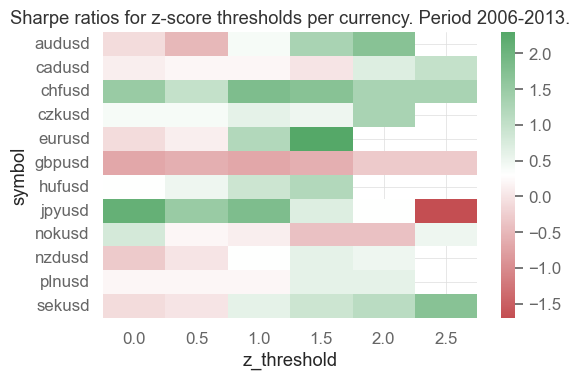

In [146]:
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

df = pf1.sharpe_ratio.reset_index().groupby(['bes_z_threshold', 'symbol'])['sharpe_ratio'].aggregate('first').unstack()
df.index.name = 'z_threshold'
df = round(df, 1)
df.index = np.round(df.index, 2)
_, ax = plt.subplots(1,1,figsize=(6,4))
sns.heatmap(df.T, cmap=cmap, annot=False, ax=ax)
ax.set_title('Sharpe ratios for z-score thresholds per currency. Period 2006-2013.')
plt.tight_layout()

### Out of sample: 2014-2023

In [150]:
# Optimal in-sample z-thresholds:
x = [
    ('audusd', 2.0), ('cadusd', 2.5), ('chfusd', 1.0),
    ('czkusd', 2.0), ('eurusd', 1.5), ('gbpusd', 2.5),
    ('hufusd', 1.5), ('jpyusd', 0), ('nokusd', 0),
    ('nzdusd', 1.5), ('plnusd', 2.0), ('sekusd', 2.5)
]

pf2 = vbt.Portfolio.from_signals(
    close=data.get('close')['2014':], 
    entries=strat2.long_entry.astype(bool), 
    short_entries=strat2.short_entry.astype(bool),
    exits=strat2.long_exit.astype(bool),
    short_exits=strat2.short_exit.astype(bool), 
    fees=0.0,
    freq='D',
)

for s, z in x:
    print(s, z, pf2[z][s].sharpe_ratio) 

audusd 2.0 nan
cadusd 2.5 nan
chfusd 1.0 1.4639592566198518
czkusd 2.0 1.62572086442425
eurusd 1.5 1.7189500003163296
gbpusd 2.5 nan
hufusd 1.5 3.013505439884242
jpyusd 0 -0.5258168191219231
nokusd 0 -1.3403354992911813
nzdusd 1.5 0.7245827913105822
plnusd 2.0 2.275140652514698
sekusd 2.5 nan


In [151]:
pf2[1]['chfusd']['2014':].plot(subplots = ['trades', ('cumulative_returns', dict(
        title='Cumulative Returns',
        yaxis_kwargs=dict(title='Cumulative returns'),
        plot_func='returns.vbt.returns.cumulative.vbt.plot',
        pass_add_trace_kwargs=True)
    )]).show()

In [153]:
def beer_strat_pf(close, index_slice, signals, top_n=3, long_only=True):
    # long top 3 undervalued and short 
    signal_today = signals[index_slice].flatten()
    weights = np.zeros_like(signal_today)
    if np.all(np.isnan(signal_today)): return weights
    
    signal_ranked_idx = signal_today.argsort()    
    weight = 1/top_n if long_only else 1/(top_n*2)
    np.put(weights, signal_ranked_idx[:top_n], weight)
    if not long_only:
        np.put(weights, signal_ranked_idx[-top_n:], -weight)
    
    return weights



pf = vbt.PortfolioOptimizer.from_optimize_func(
    data.get_symbol_wrapper(freq="M") ,
    beer_strat_pf,
    close_data,
    vbt.Rep("index_slice"),
    signals=z_scores.shift(-1).values,  # shift one back as vectorbt takes next bar (month) to trade; not necessary here
    top_n=vbt.Param([3]),
    long_only=vbt.Param([False]),
    lookback_period=1,
    show_progress=False,
    every=pd.offsets.DateOffset(months=1)
 )

sim2 = pf.simulate(close_data, bm_close=None, fees=0.0, freq='D')
print(sim2.sharpe_ratio)
sim2['2014':].plot().show()

0.7198157475478733


/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/vectorbtpro/generic/plots_builder.py:396: UserWarning:

Subplot 'orders' does not support grouped data

/Users/tdrxy/opt/anaconda3/envs/vectorbtenv/lib/python3.10/site-packages/vectorbtpro/generic/plots_builder.py:396: UserWarning:

Subplot 'trade_pnl' does not support grouped data



In [154]:
fig = pf['2014':].plot().show()
# import plotly.io as pio
# pio.write_image(fig, 'image.png',scale=6, width=1080/1.5, height=1080/3)